In [40]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import operator

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid', context='notebook')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn import metrics
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
# Load data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
test_df.drop(['QuoteNumber'], axis=1, inplace=True)
train_df.drop(['QuoteNumber'], axis=1, inplace=True)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260753 entries, 0 to 260752
Columns: 298 entries, Original_Quote_Date to GeographicField64
dtypes: float64(6), int64(264), object(28)
memory usage: 594.8+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173836 entries, 0 to 173835
Columns: 297 entries, Original_Quote_Date to GeographicField64
dtypes: float64(6), int64(263), object(28)
memory usage: 395.2+ MB


In [8]:
train_df.head(3)

,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,17,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,6,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,7,...,15,18,-1,21,-1,11,-1,8,N,NJ


In [9]:
# Convert Date to Year, Month, and Week
train_df['Date'] = pd.to_datetime(pd.Series(train_df['Original_Quote_Date']))
train_df['Year']  = train_df['Date'].apply(lambda x: int(str(x)[:4]))
train_df['Month'] = train_df['Date'].apply(lambda x: int(str(x)[5:7]))
train_df['Weekday']  = train_df['Date'].dt.dayofweek

test_df['Date'] = pd.to_datetime(pd.Series(test_df['Original_Quote_Date']))
test_df['Year']  = test_df['Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Date'].apply(lambda x: int(str(x)[5:7]))
test_df['Weekday']  = test_df['Date'].dt.dayofweek

train_df.drop(['Original_Quote_Date', 'Date'], axis=1, inplace=True)
test_df.drop(['Original_Quote_Date', 'Date'], axis=1, inplace=True)

In [10]:
train_df.shape

(260753, 300)

D:\Work\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
D:\Work\Anaconda3\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


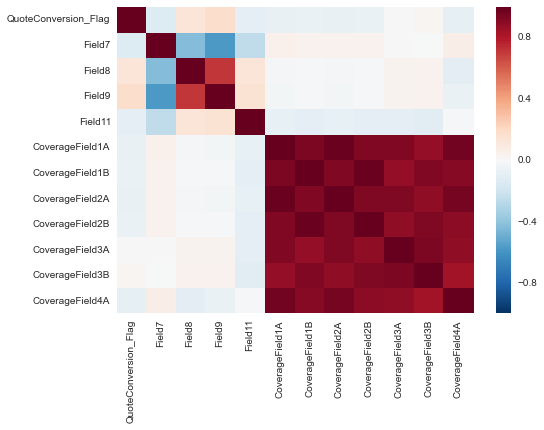

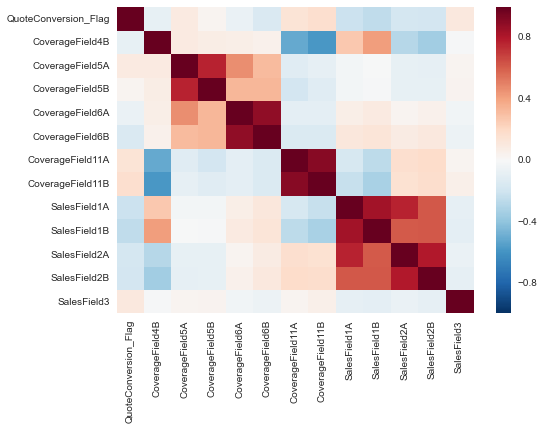

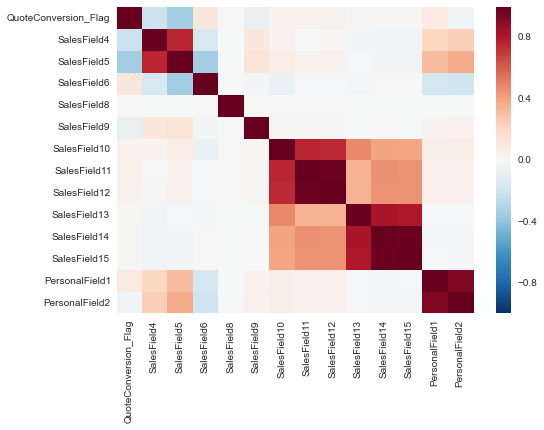

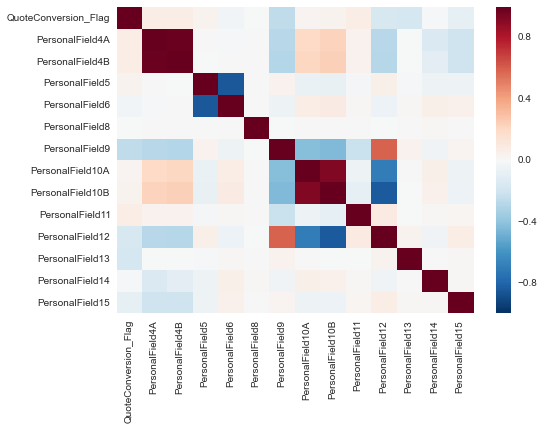

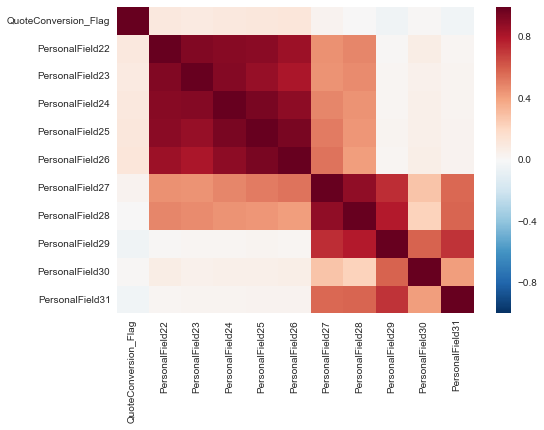

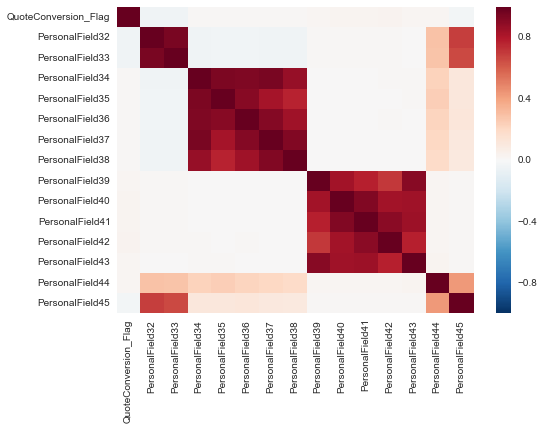

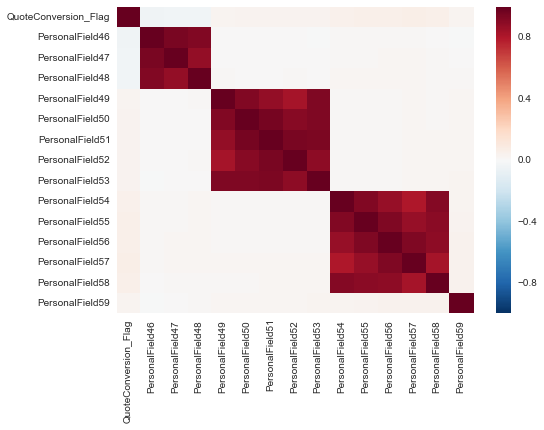

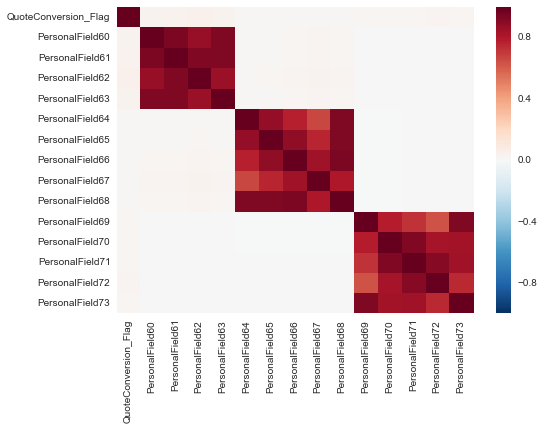

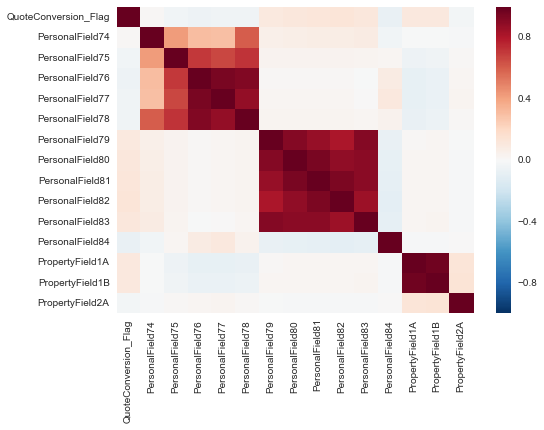

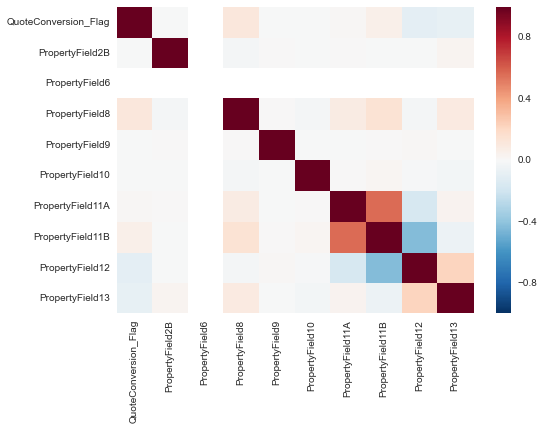

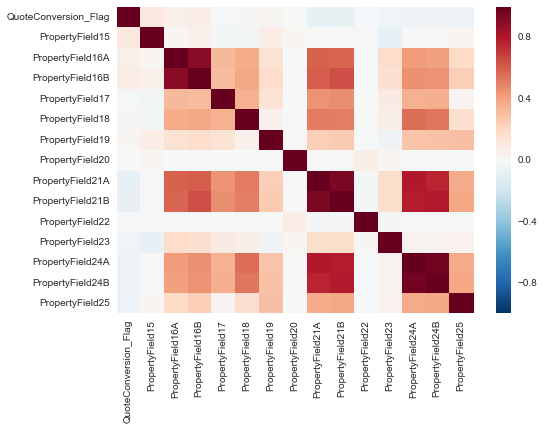

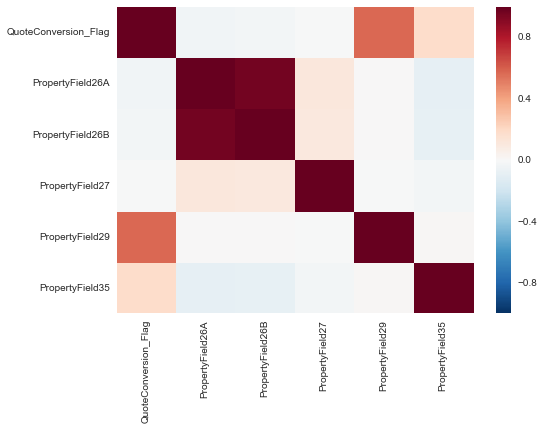

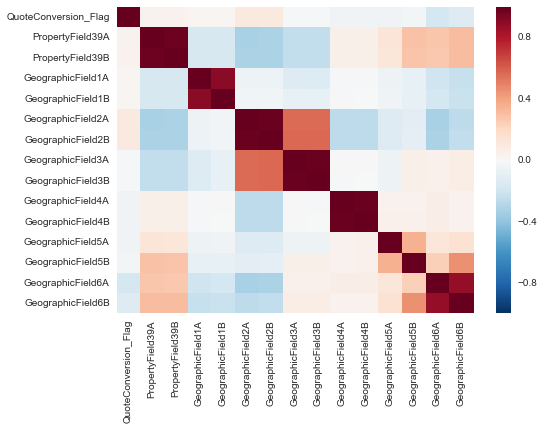

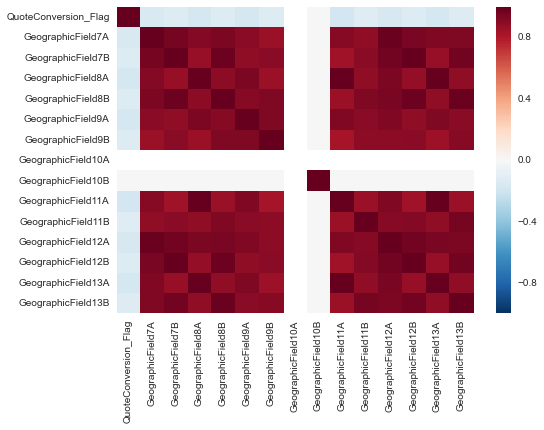

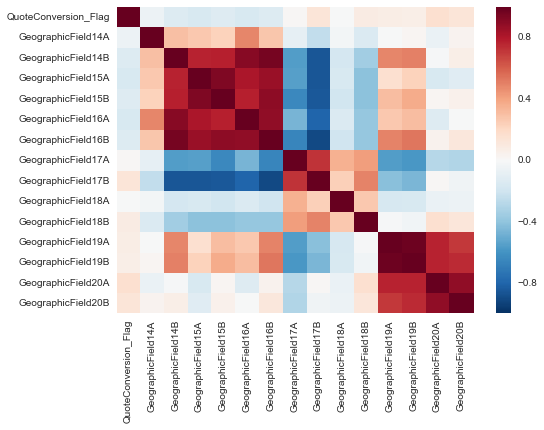

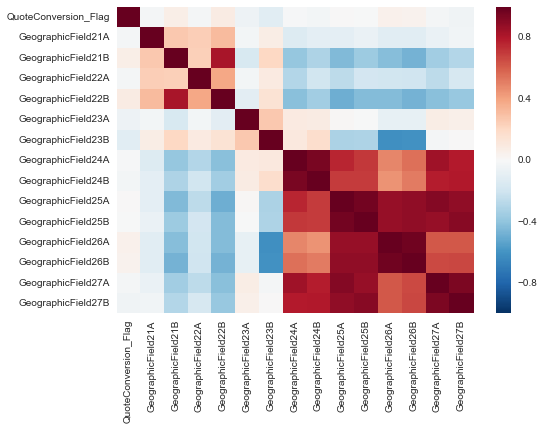

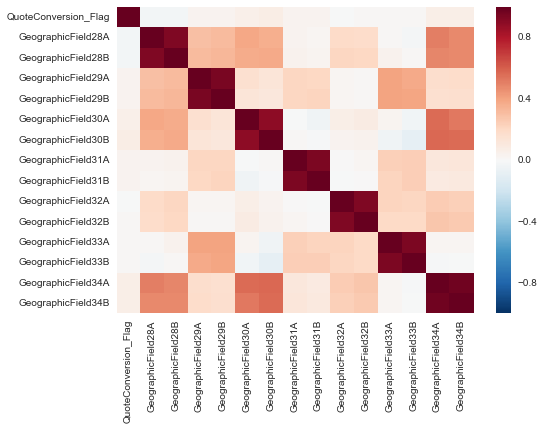

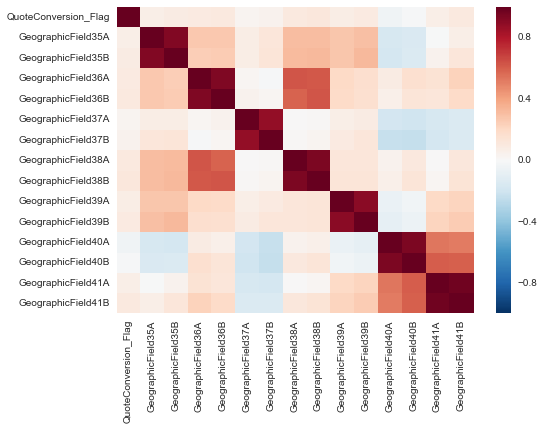

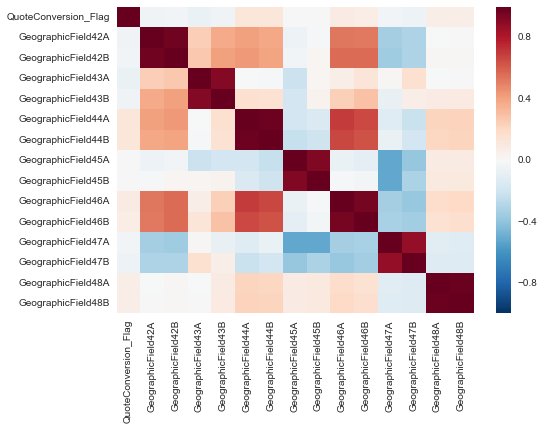

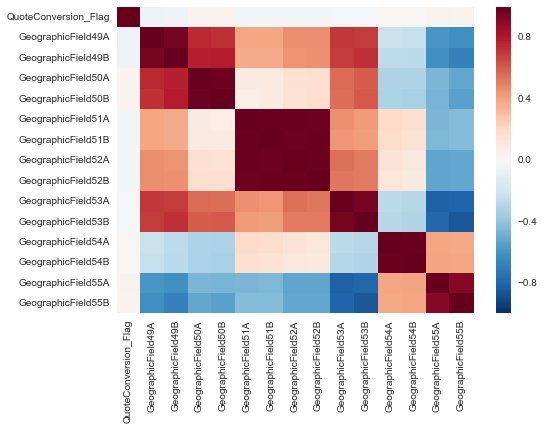

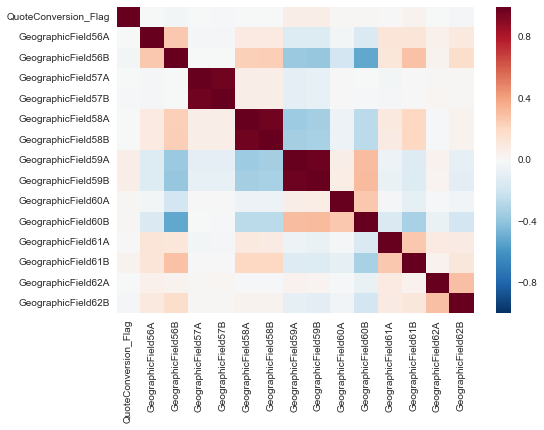

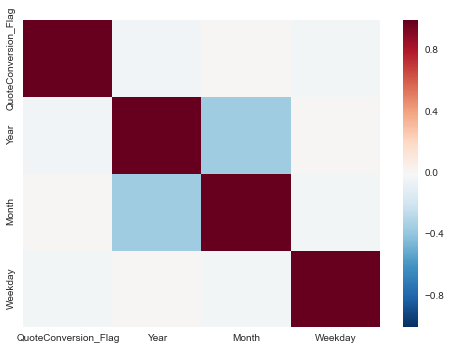

In [11]:
#train_df['Weekday'].head(20)
features = train_df.columns.tolist()
#features
start, end = 1, len(features)
while start < end:
    sub_features = ['QuoteConversion_Flag'] + features[start:min(start + 14, end)]
    plt.figure()
    sns.heatmap(train_df[sub_features].corr())
    start = start + 14

In [12]:
# Find columns which have null values, Usually it can be done by train_df.isnull().sum()
for col in train_df.columns:
    if train_df[col].isnull().sum() != 0:
        print(col, train_df[col].isnull().sum())
        print(train_df[col].value_counts())

PersonalField7 113
N    259379
Y      1261
Name: PersonalField7, dtype: int64
PersonalField84 124208
2    134906
1      1564
5        62
3         7
7         3
4         2
8         1
Name: PersonalField84, dtype: int64
PropertyField3 81
N    226966
Y     33706
Name: PropertyField3, dtype: int64
PropertyField4 63
N    226223
Y     34467
Name: PropertyField4, dtype: int64
PropertyField29 200685
0    60056
1       12
Name: PropertyField29, dtype: int64
PropertyField32 70
Y    191627
N     69056
Name: PropertyField32, dtype: int64
PropertyField34 70
Y    141185
N    119498
Name: PropertyField34, dtype: int64
PropertyField36 113
N    248302
Y     12338
Name: PropertyField36, dtype: int64
PropertyField38 1220
N    254032
Y      5501
Name: PropertyField38, dtype: int64


In [13]:
test_df.shape

(173836, 299)

In [14]:
# Find columns which have null values, Usually it can be done by test_df.isnull().sum()
for col in test_df.columns:
    if test_df[col].isnull().sum() != 0:
        print(col, test_df[col].isnull().sum())
        print(test_df[col].value_counts())

PersonalField7 69
N    172973
Y       794
Name: PersonalField7, dtype: int64
PersonalField84 82812
2    89941
1     1028
5       45
3        9
7        1
Name: PersonalField84, dtype: int64
PropertyField3 69
N    151235
Y     22532
Name: PropertyField3, dtype: int64
PropertyField4 52
N    150644
Y     23140
Name: PropertyField4, dtype: int64
PropertyField5 1
Y    173768
N        67
Name: PropertyField5, dtype: int64
PropertyField29 133945
0     39879
1        10
10        2
Name: PropertyField29, dtype: int64
PropertyField30 1
N    164135
Y      9700
Name: PropertyField30, dtype: int64
PropertyField32 41
Y    128082
N     45713
Name: PropertyField32, dtype: int64
PropertyField34 41
Y    93784
N    80011
Name: PropertyField34, dtype: int64
PropertyField36 67
N    165619
Y      8150
Name: PropertyField36, dtype: int64
PropertyField38 846
N    169171
Y      3819
Name: PropertyField38, dtype: int64


In [15]:
# fill NaN values. We don't need to do this, xgboost does it automatically
#train_df.fillna(-1, inplace=True)
#test_df.fillna(-1, inplace=True)

In [16]:
#train_df[pd.isnull(train_df['PersonalField7'])].head(3)

In [17]:
# scatter plot matrix
#sns.pairplot(yelp, kind='reg')

# limit scatter plot matrix and add regression lines
#sns.pairplot(yelp, x_vars=['cool', 'useful', 'funny'], y_vars='stars', size=6, aspect=0.7, kind='reg')

In [18]:
# How many customers purchased insurance plan
#sns.countplot(x="QuoteConversion_Flag", data=train_df)

In [19]:
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# how many customers bought or did not buy policy
#sns.countplot(x='QuoteConversion_Flag', data=train_df, hue='Year', ax=ax1)

# which year has highest number of policies bought
#sns.countplot(x=train_df['Year'].loc[train_df['QuoteConversion_Flag'] == 1], order=[2013,2014,2015], ax=ax2)

In [20]:
# which month has highest number of policies bought
#sns.countplot(x=train_df['Month'].loc[train_df['QuoteConversion_Flag'] == 1], order=[1,2,3,4,5,6,7,8,9,10,11,12])

In [21]:
# There are some columns with non-numerical values(i.e. dtype='object'),
# So, We will create a corresponding unique numerical value for each non-numerical value in a column of training and testing set.

from sklearn import preprocessing

for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl_encoder = preprocessing.LabelEncoder()
        lbl_encoder.fit(np.unique(list(train_df[f].values) + list(test_df[f].values)))
        train_df[f] = lbl_encoder.transform(list(train_df[f].values))
        test_df[f] = lbl_encoder.transform(list(test_df[f].values))

Field6
Field10
Field12
CoverageField8
CoverageField9
SalesField7
PersonalField7
PersonalField16
PersonalField17
PersonalField18
PersonalField19
PropertyField3
PropertyField4
PropertyField5
PropertyField7
PropertyField14
PropertyField28
PropertyField30
PropertyField31
PropertyField32
PropertyField33
PropertyField34
PropertyField36
PropertyField37
PropertyField38
GeographicField63
GeographicField64


In [22]:
# define training and testing sets
y_train = train_df['QuoteConversion_Flag']
X_train = train_df.drop('QuoteConversion_Flag', axis=1)
X_test  = test_df.copy()
X_test = X_test[X_train.columns.tolist()] # maintain same column order between train and test data

In [23]:
print(X_train.columns)
print(X_test.columns)

Index(['Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12',
       'CoverageField1A', 'CoverageField1B', 'CoverageField2A',
       ...
       'GeographicField60B', 'GeographicField61A', 'GeographicField61B',
       'GeographicField62A', 'GeographicField62B', 'GeographicField63',
       'GeographicField64', 'Year', 'Month', 'Weekday'],
      dtype='object', length=299)
Index(['Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12',
       'CoverageField1A', 'CoverageField1B', 'CoverageField2A',
       ...
       'GeographicField60B', 'GeographicField61A', 'GeographicField61B',
       'GeographicField62A', 'GeographicField62B', 'GeographicField63',
       'GeographicField64', 'Year', 'Month', 'Weekday'],
      dtype='object', length=299)


In [24]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [41]:
# stratified sampling of training and test data
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_train, y_train, train_size=0.75, stratify=y_train)

xgb_clf = xgb.XGBClassifier(n_estimators=25,
                        objective="binary:logistic",
                        nthread=-1,
                        max_depth=10,
                        learning_rate=0.025,
                        silent=True,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=np.nan)

xgb_model = xgb_clf.fit(X_train_data, y_train_data, eval_metric="auc")

y_valid_pred = xgb_clf.predict(X_valid_data)

train_acc = metrics.roc_auc_score(y_valid_data, y_valid_pred)
print('XGBoostClassifier Training accuracy: %.2f%%' % (train_acc * 100))

XGBoostClassifier Training accuracy: 81.53%


In [42]:
# 5 Fold Cross Validation on with scikit metrics.accuracy_score()
skf = StratifiedKFold(y_train, n_folds=5)

xgb_clf = xgb.XGBClassifier(n_estimators=25,
                        objective="binary:logistic",
                        nthread=-1,
                        max_depth=10,
                        learning_rate=0.025,
                        silent=True,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=np.nan)

scores = cross_val_score(xgb_clf,
                         X_train, # training data
                         y_train, # training labels
                         cv=skf,
                         scoring='roc_auc',  # which scoring metric?
                         n_jobs=-1  # -1 = use all cores = faster
                         )
print('XGBoostClassifier Cross Validation accuracy: %.2f%%' % (np.array(scores).mean() * 100))

XGBoostClassifier Cross Validation accuracy: 95.87%


In [62]:
# 5 Fold Cross Validation manually, validating with above, should be same; just doublechecking
xgb_clf = xgb.XGBClassifier(n_estimators=25,
                        objective="binary:logistic",
                        nthread=-1,
                        max_depth=10,
                        learning_rate=0.025,
                        silent=True,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        missing=np.nan)

scores = []
for train_index, test_index in skf:
    xgb_clf.fit(X_train.iloc[train_index], y_train.iloc[train_index], eval_metric="auc")
    y_pred = xgb_clf.predict_proba(X_train.iloc[test_index])
    scores.append(metrics.roc_auc_score(y_train.iloc[test_index], y_pred[:,1]))

print('XGBoostClassifier Cross Validation accuracy: %.2f%%' % (np.array(scores).mean() * 100))

XGBoostClassifier Cross Validation accuracy: 95.87


In [63]:
features = list(X_train.columns)
ceate_feature_map(features)

In [ ]:
# Calculae Feature Importance of the attributes
xgb_params = {"n_estimators":25, "objective": "binary:logistic", "eta": 0.025, "max_depth": 10, "silent": 1, "eval_metric": "auc"}
num_rounds = 10

dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

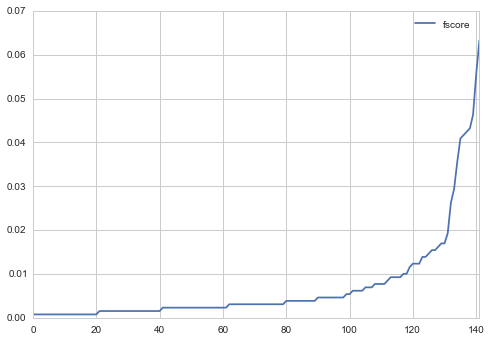

In [71]:
plt.figure()
df.plot()

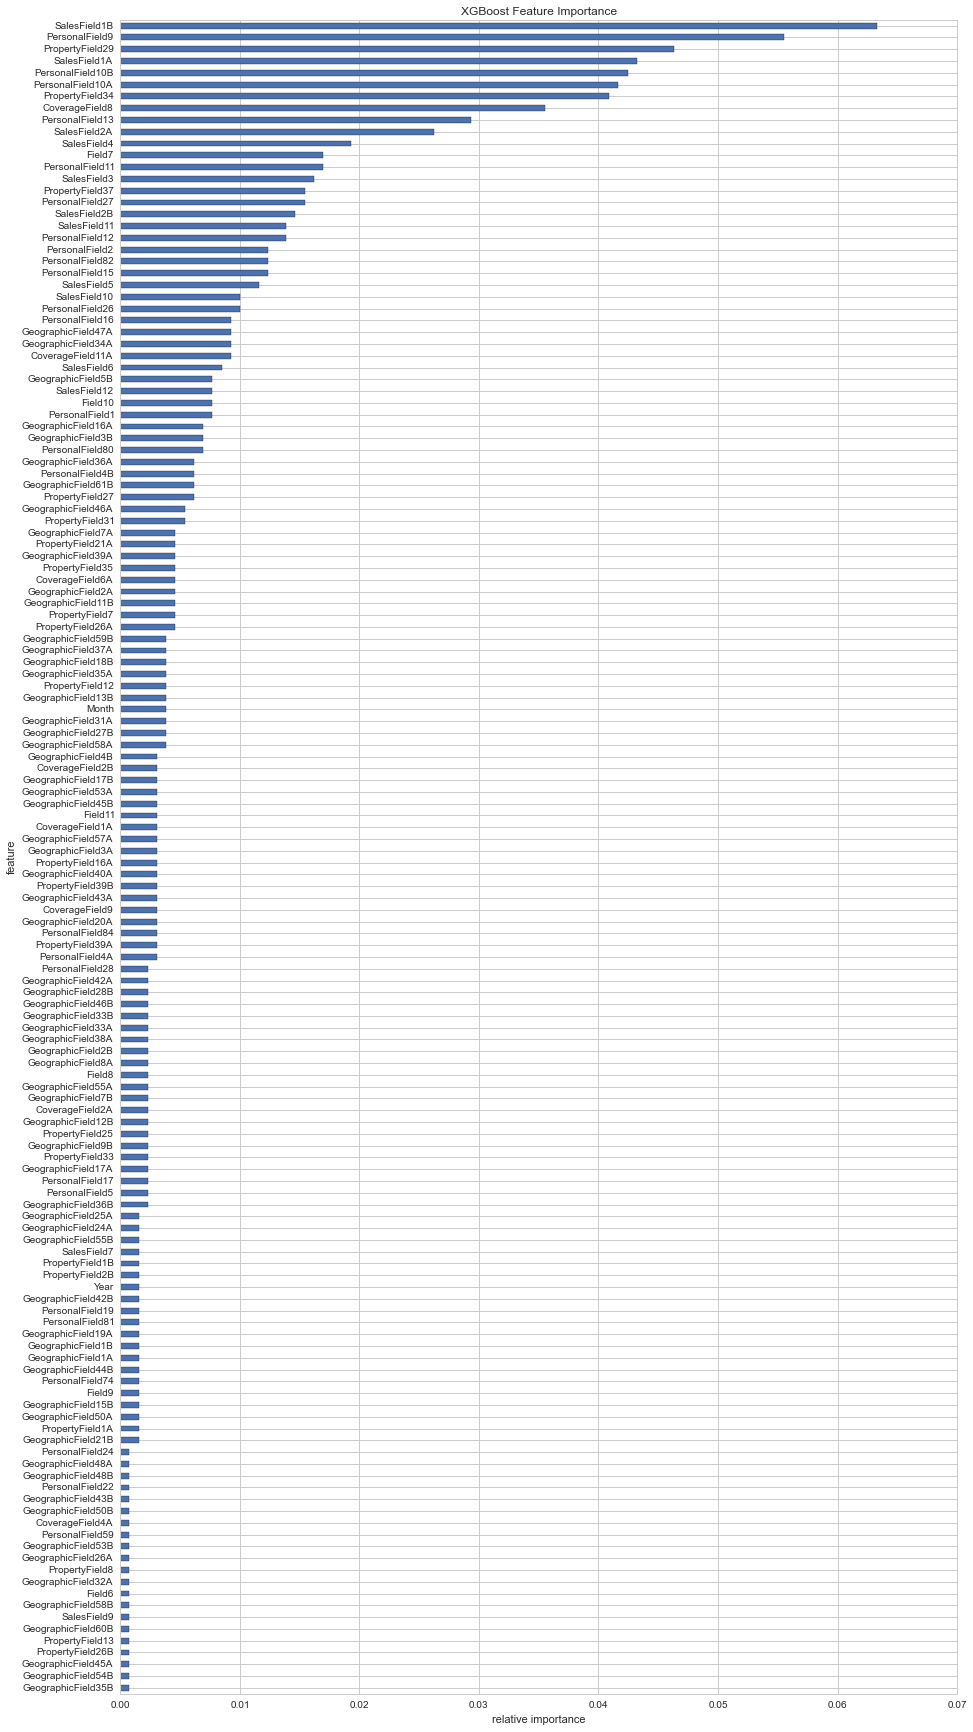

In [73]:
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(15, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#plt.gcf().savefig('feature_importance_xgb.png')

In [88]:
# Low Importance Features
low_importance_features = []
low_importance_features.append(df[0:21]['feature'].tolist())
low_importance_features.append(df[0:41]['feature'].tolist())
low_importance_features

[['GeographicField35B',
  'GeographicField54B',
  'GeographicField45A',
  'PropertyField26B',
  'PropertyField13',
  'GeographicField60B',
  'SalesField9',
  'GeographicField58B',
  'Field6',
  'GeographicField32A',
  'PropertyField8',
  'GeographicField26A',
  'GeographicField53B',
  'PersonalField59',
  'CoverageField4A',
  'GeographicField50B',
  'GeographicField43B',
  'PersonalField22',
  'GeographicField48B',
  'GeographicField48A',
  'PersonalField24'],
 ['GeographicField35B',
  'GeographicField54B',
  'GeographicField45A',
  'PropertyField26B',
  'PropertyField13',
  'GeographicField60B',
  'SalesField9',
  'GeographicField58B',
  'Field6',
  'GeographicField32A',
  'PropertyField8',
  'GeographicField26A',
  'GeographicField53B',
  'PersonalField59',
  'CoverageField4A',
  'GeographicField50B',
  'GeographicField43B',
  'PersonalField22',
  'GeographicField48B',
  'GeographicField48A',
  'PersonalField24',
  'GeographicField21B',
  'PropertyField1A',
  'GeographicField50A',
  

In [89]:
for low_importance_feature_set in low_importance_features:
    # Drop unwanted Features
    X_train_reduced = X_train.drop(low_importance_feature_set, axis=1)
    X_test_reduced = X_test.drop(low_importance_feature_set, axis=1)
    
    # 5 Fold Cross Validation with reduced features
    xgb_clf = xgb.XGBClassifier(n_estimators=25,
                            objective="binary:logistic",
                            nthread=-1,
                            max_depth=10,
                            learning_rate=0.025,
                            silent=True,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            missing=np.nan)

    scores = cross_val_score(xgb_clf,
                             X_train_reduced, # training data
                             y_train, # training labels
                             cv=skf,
                             scoring='roc_auc',  # which scoring metric?
                             n_jobs=-1  # -1 = use all cores = faster
                             )
    print('XGBoostClassifier Cross Validation Accuracy With %s Reduced Features: %.2f%%' % (len(low_importance_feature_set), np.array(scores).mean() * 100))

XGBoostClassifier Cross Validation Accuracy With 21 Reduced Features: 95.90%
XGBoostClassifier Cross Validation Accuracy With 41 Reduced Features: 95.91%


In [91]:
# GridSearchCV with XGBoost 
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            nthread=-1,
                            learning_rate=0.025,
                            silent=True,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            missing=np.nan)

In [ ]:
from sklearn.grid_search import GridSearchCV
X_train_reduced = X_train.drop(low_importance_feature_set[0], axis=1)
param_grid = {'max_depth': [6,8,],
              'n_estimators': [200,500]}

gs = GridSearchCV(xgb_clf,
                  param_grid,
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=1,
                  verbose=1)

gs.fit(X_train_reduced, y_train)
gs.best_score_, gs.best_params_
print(gs.best_estimator_)

In [ ]:
#clf = gs.best_estimator_
#clf.fit(X_train, y_train)
#y_pred_proba = clf.predict_proba(X_test)[:,1]

In [ ]:
# Create submission
#sample = pd.read_csv('data/sample_submission.csv')
#sample.QuoteConversion_Flag = y_pred_proba
#sample.head(10)

In [ ]:
#sample.to_csv('xgb_benchmark.csv', index=False)